## Human Activity Recognition (HAR) with Smartphones

# Library

In [171]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

# data processing
from sklearn.preprocessing import StandardScaler

# model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# obsolete imports since it use for GUI before this version
import joblib
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os




# Load Data

In [82]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

combined to prevent any data leakage at initial 

In [ ]:
# Combine boths dataframes 

train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
combined_df= pd.concat([train_df, test_df], axis=0).reset_index(drop=True) 
combined_df['subject'] = '#' + combined_df['subject'].astype(str)
    
# Create label
label = combined_df.pop('Activity') 

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


# Data Set Exploration

In [84]:
missing_values = combined_df.isnull().sum() # count of missing values in each column
print(missing_values)

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Data                    0
Length: 563, dtype: int64


In [85]:
pd.Series([col.split('-')[0].split('(')[0] for col in combined_df.columns])\
  .value_counts()\
  .rename_axis('main_name')\
  .reset_index(name='count')

,main_name,count
0,fBodyAccJerk,79
1,fBodyGyro,79
2,fBodyAcc,79
3,tBodyAcc,40
4,tBodyGyro,40
5,tBodyAccJerk,40
6,tGravityAcc,40
7,tBodyGyroJerk,40
8,tBodyAccJerkMag,13
9,tGravityAccMag,13


In [86]:
print(combined_df.dtypes)
print("\n")
print(combined_df.dtypes.value_counts())


tBodyAcc-mean()-X       float64
tBodyAcc-mean()-Y       float64
tBodyAcc-mean()-Z       float64
tBodyAcc-std()-X        float64
tBodyAcc-std()-Y        float64
                         ...   
angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                  object
Data                     object
Length: 563, dtype: object


float64    561
object       2
Name: count, dtype: int64


In [87]:
train_df['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

<Axes: xlabel='Activity', ylabel='count'>

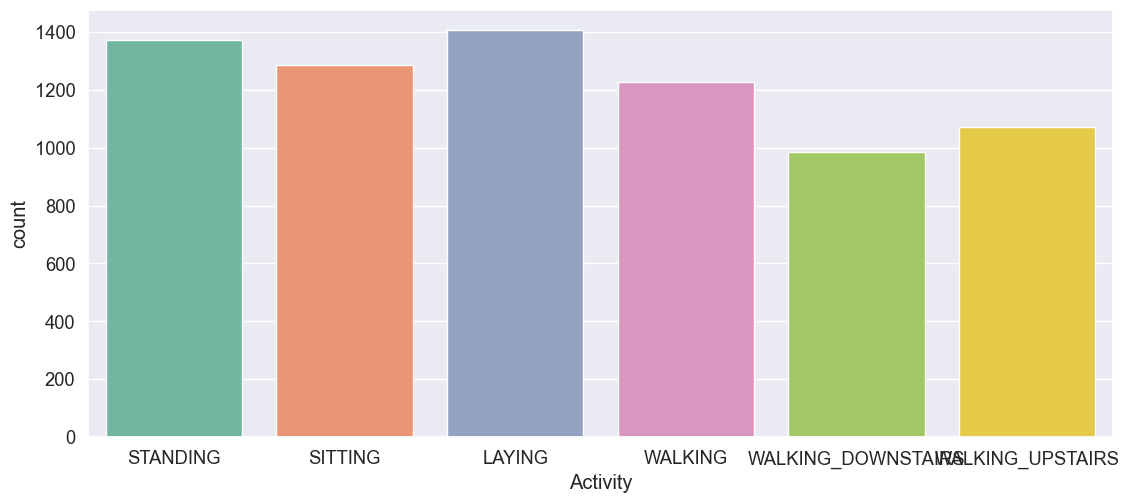

In [88]:
plt.figure(dpi=100)
plt.subplots_adjust(left=0.9, right=2.5, top=1)

sns.countplot(x="Activity", hue="Activity", data=train_df, palette="Set2", legend=False)

# Preprocessing

split the data frame back and apply standard scaler

In [89]:
numeric_cols = combined_df.select_dtypes(include='number').columns
scaler = StandardScaler()
combined_df[numeric_cols] = scaler.fit_transform(combined_df[numeric_cols])

In [90]:
X_train = combined_df[combined_df['Data'] == 'Train'].drop(columns=['Data', 'subject'])
X_test = combined_df[combined_df['Data'] == 'Test'].drop(columns=['Data', 'subject'])
y_train = label[combined_df['Data'] == 'Train']
y_test = label[combined_df['Data'] == 'Test']

In [91]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.819093,-0.000264,-0.299902,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,0.127803,-0.925905,-0.789555,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,1.172610,-0.287824,-0.461181,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,1.132149,0.566244,0.436736,-0.132194,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,-0.158720,-0.165153,-0.263958,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649


In [92]:
y_train.head()

0    STANDING
1    STANDING
2    STANDING
3    STANDING
4    STANDING
Name: Activity, dtype: object

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model 

for the model I do each one by one with each model has parameter tuning with time is taken after the tuning occur, since parameter tuning is taken quite a minute to do you can (control + C) line for code of hyper parameter tuning or use the parameter tuning that i got below

# Model (logistic Regression)

In [94]:
print(f"\n=== Logistic Regression ===")

start_time = time.time()

# Train and evaluate Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

elapsed_time = time.time() - start_time

# Display results
print("\nAccuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== Logistic Regression ===

Accuracy: 0.9548693586698337
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.97      0.88      0.92       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.94      0.96       420
  WALKING_UPSTAIRS       0.96      0.95      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947

Training Time: 1.3033 seconds


In [114]:
print(f"\n=== Logistic Regression - Hyperparameter Tuning ===")

# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1.0, 1.1, 0.1],  # Regularization strength
    'penalty': ['l2','l1'],  # Regularization type
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=5, solver='liblinear', max_iter=1000)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)



# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

start_time = time.time()

# Get the best model
best_log_reg = grid_search.best_estimator_

# Evaluate the best model
y_pred_log_reg = best_log_reg.predict(X_test_scaled)

# Elapsed time after hyperparameter tuning
elapsed_time = time.time() - start_time

# Display results
print("\nBest Hyperparameters:", best_params)
print("\nAccuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print(f"Training Time: {elapsed_time:.4f} seconds")



=== Logistic Regression - Hyperparameter Tuning ===

Best Hyperparameters: {'C': 1.0, 'penalty': 'l1'}

Accuracy: 0.9599592806243638
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.86      0.91       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.95      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training Time: 0.0050 seconds


Best Hyperparameter: {'C': 1.0, 'penalty': 'l1'}

# Model (KNN)

In [97]:
print(f"\n=== KNN (k=5) ===")

start_time = time.time()

# Train and evaluate KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

elapsed_time = time.time() - start_time

# Display results
print("\nAccuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== KNN (k=5) ===

Accuracy: 0.8836104513064132
Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.99      0.96      0.98       537
           SITTING       0.88      0.76      0.82       491
          STANDING       0.80      0.93      0.86       532
           WALKING       0.82      0.97      0.89       496
WALKING_DOWNSTAIRS       0.95      0.75      0.84       420
  WALKING_UPSTAIRS       0.90      0.89      0.89       471

          accuracy                           0.88      2947
         macro avg       0.89      0.88      0.88      2947
      weighted avg       0.89      0.88      0.88      2947

Training Time: 0.5395 seconds


In [98]:
print(''"\n=== KNN (Hyperparameter Tuning) ===")
# Hyperparameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Example values for k
    'weights': ['uniform', 'distance'],  # Example for weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for computing nearest neighbors
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_

start_time = time.time()

# Get the best model
best_knn = grid_search.best_estimator_

# Evaluate the best model
y_pred_knn = best_knn.predict(X_test_scaled)

# Elapsed time after hyperparameter tuning
elapsed_time = time.time() - start_time

# Display results
print("\nBest Hyperparameters:", best_params)
print("\nAccuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== KNN (Hyperparameter Tuning) ===

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'}

Accuracy: 0.8866644044791313
Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.99      0.95      0.97       537
           SITTING       0.90      0.77      0.83       491
          STANDING       0.81      0.95      0.87       532
           WALKING       0.82      0.98      0.90       496
WALKING_DOWNSTAIRS       0.98      0.75      0.85       420
  WALKING_UPSTAIRS       0.88      0.89      0.89       471

          accuracy                           0.89      2947
         macro avg       0.90      0.88      0.88      2947
      weighted avg       0.90      0.89      0.89      2947

Training Time: 0.5301 seconds


Best Hyperparameter: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'}

# Model: SVM (Linear)

In [99]:
print(f"\n=== SVM (Linear) ===")


start_time = time.time()

# Train and evaluate SVM (Linear) model
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train_scaled, y_train)
y_pred_svm_linear = svm_linear.predict(X_test_scaled)

elapsed_time = time.time() - start_time

# Display results
print("\nAccuracy:", accuracy_score(y_test, y_pred_svm_linear))
print("Classification Report:\n", classification_report(y_test, y_pred_svm_linear))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== SVM (Linear) ===

Accuracy: 0.9606379368849678
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training Time: 2.1987 seconds


In [100]:
print(f"\n=== SVM (Linear) - Hyperparameter Tuning ===")

# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],  # Tolerance for stopping criteria
}

# Initialize SVM model with linear kernel
svm_linear = SVC(kernel='linear')

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=svm_linear, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

start_time = time.time()

# Get the best model
best_svm_linear = grid_search.best_estimator_

# Evaluate the best model
y_pred_svm_linear = best_svm_linear.predict(X_test_scaled)

# Elapsed time after hyperparameter tuning
elapsed_time = time.time() - start_time

# Display results
print("\nBest Hyperparameters:", best_params)
print("\nAccuracy:", accuracy_score(y_test, y_pred_svm_linear))
print("Classification Report:\n", classification_report(y_test, y_pred_svm_linear))
print(f"Training Time: {elapsed_time:.4f} seconds")



=== SVM (Linear) - Hyperparameter Tuning ===

Best Hyperparameters: {'C': 0.1, 'tol': 0.0001}

Accuracy: 0.9616559212758737
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training Time: 0.5293 seconds


Best Hyperparameter: {'C': 0.1, 'tol': 0.0001}

# Mode: SVM (RBF)

In [101]:
print(f"\n=== SVM (RBF) ===")

start_time = time.time()

# Train and evaluate SVM (RBF) model
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train_scaled, y_train)
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)

elapsed_time = time.time() - start_time

# Display results
print("\nAccuracy:", accuracy_score(y_test, y_pred_svm_rbf))
print("Classification Report:\n", classification_report(y_test, y_pred_svm_rbf))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== SVM (RBF) ===

Accuracy: 0.9518154054971157
Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.94      0.90      0.92       491
          STANDING       0.92      0.95      0.93       532
           WALKING       0.96      0.97      0.97       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.93      0.97      0.95       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947

Training Time: 7.9865 seconds


In [102]:
print(f"\n=== SVM (RBF) - Hyperparameter Tuning ===")

# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient for 'rbf'
}

# Initialize SVM model with RBF kernel
svm_rbf = SVC(kernel='rbf')

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

start_time = time.time()

# Get the best model
best_svm_rbf = grid_search.best_estimator_

# Evaluate the best model
y_pred_svm_rbf = best_svm_rbf.predict(X_test_scaled)

# Elapsed time after hyperparameter tuning
elapsed_time = time.time() - start_time

# Display results
print("\nBest Hyperparameters:", best_params)
print("\nAccuracy:", accuracy_score(y_test, y_pred_svm_rbf))
print("Classification Report:\n", classification_report(y_test, y_pred_svm_rbf))
print(f"Training Time: {elapsed_time:.4f} seconds")



=== SVM (RBF) - Hyperparameter Tuning ===

Best Hyperparameters: {'C': 10, 'gamma': 0.001}

Accuracy: 0.9548693586698337
Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.93      0.95       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947

Training Time: 2.7719 seconds


Best Hyperparameter: {'C': 10, 'gamma': 0.001}

# Model: Naive Bayes

In [103]:
print(f"\n=== Naive Bayes ===")

start_time = time.time()

# Train and evaluate Naive Bayes model
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)

elapsed_time = time.time() - start_time

# Display results
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== Naive Bayes ===
Accuracy: 0.7702748557855447
Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.96      0.60      0.74       537
           SITTING       0.58      0.75      0.65       491
          STANDING       0.80      0.86      0.83       532
           WALKING       0.82      0.84      0.83       496
WALKING_DOWNSTAIRS       0.83      0.61      0.70       420
  WALKING_UPSTAIRS       0.76      0.96      0.84       471

          accuracy                           0.77      2947
         macro avg       0.79      0.77      0.77      2947
      weighted avg       0.79      0.77      0.77      2947

Training Time: 0.2139 seconds


In [104]:
print(f"\n=== Naive Bayes - Hyperparameter Tuning ===")

# Define the hyperparameter grid for tuning
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Values for variance smoothing
}

# Initialize Naive Bayes model
nb = GaussianNB()

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

start_time = time.time()

# Get the best model
best_nb = grid_search.best_estimator_

# Evaluate the best model
y_pred_nb = best_nb.predict(X_test_scaled)

# Elapsed time after hyperparameter tuning
elapsed_time = time.time() - start_time

# Display results
print("\nBest Hyperparameters:", best_params)
print("\nAccuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== Naive Bayes - Hyperparameter Tuning ===

Best Hyperparameters: {'var_smoothing': 1e-05}

Accuracy: 0.7740074652188667
Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.97      0.63      0.76       537
           SITTING       0.60      0.71      0.65       491
          STANDING       0.78      0.88      0.83       532
           WALKING       0.82      0.84      0.83       496
WALKING_DOWNSTAIRS       0.83      0.61      0.70       420
  WALKING_UPSTAIRS       0.76      0.96      0.84       471

          accuracy                           0.77      2947
         macro avg       0.79      0.77      0.77      2947
      weighted avg       0.79      0.77      0.77      2947

Training Time: 0.1085 seconds


Best Hyperparameter: {'var_smoothing': 1e-05}

# Model: Decision Tree

In [105]:
print(f"\n=== Decision Tree ===")

start_time = time.time()

# Train and evaluate Decision Tree model
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

elapsed_time = time.time() - start_time

# Display results
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== Decision Tree ===
Accuracy: 0.8591788259246692
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.84      0.76      0.80       491
          STANDING       0.80      0.86      0.83       532
           WALKING       0.82      0.90      0.86       496
WALKING_DOWNSTAIRS       0.88      0.82      0.85       420
  WALKING_UPSTAIRS       0.81      0.78      0.80       471

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947

Training Time: 8.6784 seconds


In [106]:
print(f"\n=== Decision Tree - Hyperparameter Tuning ===")

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Initialize Decision Tree model
dt = DecisionTreeClassifier()

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

start_time = time.time()

# Get the best model
best_dt = grid_search.best_estimator_

# Evaluate the best model
y_pred_dt = best_dt.predict(X_test_scaled)

# Elapsed time after hyperparameter tuning
elapsed_time = time.time() - start_time

# Display results
print("\nBest Hyperparameters:", best_params)
print("\nAccuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print(f"Training Time: {elapsed_time:.4f} seconds")



=== Decision Tree - Hyperparameter Tuning ===

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Accuracy: 0.8612147947064812
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.82      0.77      0.80       491
          STANDING       0.80      0.85      0.82       532
           WALKING       0.81      0.92      0.86       496
WALKING_DOWNSTAIRS       0.88      0.85      0.87       420
  WALKING_UPSTAIRS       0.86      0.75      0.80       471

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947

Training Time: 0.0070 seconds


Best Hyperparameter: {'criterion': 'entropy', 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

# Random Forest

In [172]:
print(f"\n=== Random Forest ===")

start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, random_state=42)  
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

elapsed_time = time.time() - start_time

# Display results
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f"Training Time: {elapsed_time:.4f} seconds")



=== Random Forest ===
Accuracy: 0.9260264675941635
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.89      0.90       491
          STANDING       0.90      0.92      0.91       532
           WALKING       0.89      0.96      0.92       496
WALKING_DOWNSTAIRS       0.97      0.86      0.91       420
  WALKING_UPSTAIRS       0.89      0.90      0.90       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947

Training Time: 23.2477 seconds


In [173]:
print(f"\n=== Random Forest - Hyperparameter Tuning ===")

# Max parameter grid for tuning but it takes too long to run
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Max depth of each tree
#     'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
#     'max_features': ['auto', 'sqrt', 'log2'],  # Features to consider at each split
#     'bootstrap': [True, False],  # Use bootstrap samples or not
#     'criterion': ['gini', 'entropy']  # How to measure the quality of a split
# }

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],             # Reduce the range
    'min_samples_split': [2, 5],           # Fewer splits
    'min_samples_leaf': [1, 4],            # Just two leaf configs
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

start_time = time.time()

# Get the best model
best_rf = grid_search.best_estimator_

# Evaluate the best model
y_pred_rf = best_rf.predict(X_test_scaled)

# Elapsed time after hyperparameter tuning
elapsed_time = time.time() - start_time

# Display results
print("\nBest Hyperparameters:", best_params)
print("\nAccuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f"Training Time: {elapsed_time:.4f} seconds")


=== Random Forest - Hyperparameter Tuning ===

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Accuracy: 0.9202578893790295
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.88      0.90       491
          STANDING       0.89      0.93      0.91       532
           WALKING       0.87      0.98      0.92       496
WALKING_DOWNSTAIRS       0.96      0.82      0.89       420
  WALKING_UPSTAIRS       0.89      0.89      0.89       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

Training Time: 0.0480 seconds


Best Hyperparameter: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

# Evaluation

Best model for this data as for my implementation is Support Vector Machine Linear after hyperparameter tuning

In [107]:
labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

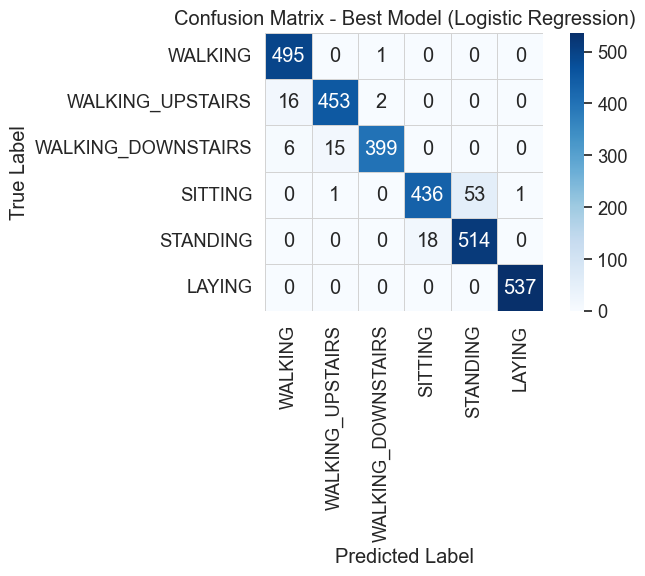

In [115]:
cm_best_model = confusion_matrix(y_test, y_pred_svm_linear, labels=labels)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,linewidths=0.4,linecolor='lightgray',square=True)
plt.title('Confusion Matrix - Best Model (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# GUI

For GUI it work by getting the model.pkl which is what the best model is then put it into GUI to test based on user data input excel spread sheet.
the data I got is from Extract_User.py this code let I take some row of data of given ID user. since I don't had a tool to get my self the data this is my idea to get the data.

then in the GUI I apply confidence evaluation, which for this model since it SVM it doesn't have native prediction probability instead using decision function which approximate via sigmoid function to get the confidence value.

for example GUI, can be seen under GUI.png.

In [175]:
model = best_svm_linear  # Load the best model from hyperparameter tuning

joblib.dump(model, 'best_model.pkl')

['best_model.pkl']

In [174]:
class ActivityClassifierApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Human Activity Classifier")
        self.root.geometry("900x750")
        
        # Try to load the model
        try:
            self.model = joblib.load('best_model.pkl')
            print("Model loaded successfully!")
            # Check if the model supports prediction probabilities
            self.has_proba = hasattr(self.model, 'predict_proba')
            model_info = f"Model: SVM with Linear Kernel (Accuracy: 96.17%)"
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model:\n{e}")
            self.model = None
            self.has_proba = False
            model_info = "Model: Not loaded"
        
        # Activity labels - these match the actual classes in your SVM model
        self.activity_labels = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
        
        # Try to extract class labels from model if available
        if self.model is not None and hasattr(self.model, 'classes_'):
            try:
                classes = self.model.classes_
                if len(classes) > 0:
                    self.activity_labels = [str(c) for c in classes]
                    print(f"Loaded class labels from model: {self.activity_labels}")
            except:
                print("Could not extract class labels from model, using defaults")

        # App title
        title_label = tk.Label(root, text="Human Activity Classifier", font=("Arial", 16, "bold"))
        title_label.pack(pady=5)
        
        # Model info
        model_label = tk.Label(root, text=model_info, font=("Arial", 10, "italic"), fg="gray")
        model_label.pack(pady=2)

        self.label = tk.Label(root, text="Upload an Excel file with activity features", font=("Arial", 12))
        self.label.pack(pady=5)

        # Button with better styling
        self.upload_button = tk.Button(root, text="Upload Excel File", command=self.upload_file,
                                    bg="#4CAF50", fg="white", font=("Arial", 11), padx=10, pady=5)
        self.upload_button.pack(pady=5)

        # Result labels with icon
        self.result_frame = tk.Frame(root)
        self.result_frame.pack(pady=5, fill='x')
        
        self.result_label = tk.Label(self.result_frame, text="", font=("Arial", 14, "bold"), fg="blue")
        self.result_label.pack(side='top', pady=2)
        
        # Confidence label with percentage and progressbar
        self.conf_frame = tk.Frame(root)
        self.conf_frame.pack(pady=2, fill='x')
        
        self.confidence_label = tk.Label(self.conf_frame, text="", font=("Arial", 12), fg="green")
        self.confidence_label.pack(side='left', padx=20)
        
        self.conf_bar = ttk.Progressbar(self.conf_frame, orient="horizontal", length=200, mode="determinate")
        self.conf_bar.pack(side='left', padx=5)
        
        # Chart type selection with better styling
        chart_options_frame = tk.LabelFrame(root, text="Visualization Options", font=("Arial", 11), padx=10, pady=5)
        chart_options_frame.pack(pady=5, fill='x', padx=20)
        
        self.chart_type = tk.StringVar(value="Pie")
        chart_type_frame = tk.Frame(chart_options_frame)
        chart_type_frame.pack(pady=5)
        tk.Label(chart_type_frame, text="Chart Type:").pack(side="left", padx=5)
        tk.Radiobutton(chart_type_frame, text="Pie Chart", variable=self.chart_type, value="Pie", command=self.update_chart).pack(side="left")
        tk.Radiobutton(chart_type_frame, text="Bar Chart", variable=self.chart_type, value="Bar", command=self.update_chart).pack(side="left")

        # Sample selector in the same frame
        self.sample_frame = tk.Frame(chart_options_frame)
        self.sample_frame.pack(pady=5)
        tk.Label(self.sample_frame, text="Sample:").pack(side="left", padx=5)
        self.sample_selector = ttk.Combobox(self.sample_frame, width=10)
        self.sample_selector.pack(side="left")
        self.sample_selector.bind("<<ComboboxSelected>>", self.on_sample_change)

        # Notebook for charts and data
        notebook = ttk.Notebook(root)
        notebook.pack(fill='both', expand=True, padx=10, pady=5)
        
        # Chart tab
        self.chart_frame = ttk.Frame(notebook)
        notebook.add(self.chart_frame, text="Confidence Chart")
        
        # Data table tab
        self.table_frame = ttk.Frame(notebook)
        notebook.add(self.table_frame, text="Data Table")
        
        # Store the current sample index
        self.current_sample = 0
        
        # Store confidence scores
        self.confidence_scores = None
        
        # Status bar
        self.status_bar = tk.Label(root, text="Ready", bd=1, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)

    def on_sample_change(self, event):
        try:
            self.current_sample = int(self.sample_selector.get()) - 1
            self.update_display()
        except:
            pass

    def update_chart(self):
        self.update_display()

    def update_display(self):
        if hasattr(self, 'df') and self.confidence_scores is not None:
            # Update the prediction label
            prediction = self.predictions[self.current_sample]
            self.result_label.config(text=f"Predicted Activity: {prediction}")
            
            # Update confidence label
            confidence = self.confidence_scores[self.current_sample]
            max_conf_idx = np.argmax(confidence)
            max_conf = confidence[max_conf_idx] * 100
            
            # Update progress bar
            self.conf_bar["value"] = max_conf
            self.confidence_label.config(text=f"Confidence: {max_conf:.1f}%")
            
            # Update status bar
            pred_class = self.activity_labels[max_conf_idx] if max_conf_idx < len(self.activity_labels) else prediction
            precision = {"LAYING": 1.00, "SITTING": 0.96, "STANDING": 0.91, 
                         "WALKING": 0.96, "WALKING_DOWNSTAIRS": 0.99, "WALKING_UPSTAIRS": 0.97}.get(pred_class, 0.96)
            self.status_bar.config(text=f"Model precision for {pred_class}: {precision:.2f}")
            
            # Redisplay the chart
            self.display_chart()

    def upload_file(self):
        file_path = filedialog.askopenfilename(filetypes=[("Excel Files", "*.xlsx")])
        if not file_path:
            return
            
        if self.model is None:
            messagebox.showerror("Error", "Model not loaded. Cannot make predictions.")
            return

        try:
            self.df = pd.read_excel(file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read file:\n{e}")
            return

        try:
            # Prepare features - remove non-feature columns
            feature_columns = self.df.columns.tolist()
            columns_to_drop = []
            
            potential_non_features = ['activity_label', 'label', 'activity', 'id', 'timestamp', 'subject', 'user_id']
            for col in potential_non_features:
                if col in feature_columns:
                    columns_to_drop.append(col)
            
            features = self.df.drop(columns_to_drop, axis=1, errors='ignore')
            
            # Ensure all features are numeric
            for col in features.columns:
                if not pd.api.types.is_numeric_dtype(features[col]):
                    try:
                        features[col] = pd.to_numeric(features[col])
                    except:
                        features = features.drop(col, axis=1)
                        print(f"Dropped non-numeric column: {col}")
            
            # Get predictions
            self.predictions = self.model.predict(features)
            
            # Get confidence scores
            if self.has_proba:
                # Get real confidence scores from the model
                self.confidence_scores = self.model.predict_proba(features)
            else:
                # Use SVM decision function if available to get more realistic scores
                num_classes = len(self.activity_labels)
                num_samples = len(self.predictions)
                self.confidence_scores = np.zeros((num_samples, num_classes))
                
                # Try to get decision function values for better confidence approximation
                try:
                    if hasattr(self.model, 'decision_function'):
                        # For SVM, decision_function can be converted to probabilities
                        decision_values = self.model.decision_function(features)
                        
                        # Handle both OvO (one-vs-one) and OvR (one-vs-rest) SVMs
                        if decision_values.ndim == 1:  # Binary classification
                            # Convert to pseudo-probabilities with sigmoid function
                            pos_probs = 1 / (1 + np.exp(-decision_values))
                            for i in range(num_samples):
                                self.confidence_scores[i, 1] = pos_probs[i]
                                self.confidence_scores[i, 0] = 1 - pos_probs[i]
                        else:  # Multi-class
                            # Use softmax to convert decision values to pseudo-probabilities
                            exp_decision = np.exp(decision_values - np.max(decision_values, axis=1, keepdims=True))
                            probs = exp_decision / np.sum(exp_decision, axis=1, keepdims=True)
                            self.confidence_scores = probs
                    else:
                        # If no decision function, create varied confidence scores
                        for i, pred in enumerate(self.predictions):
                            # Convert prediction to index
                            if isinstance(pred, (str, np.str_)):
                                try:
                                    pred_idx = self.activity_labels.index(pred)
                                except ValueError:
                                    pred_idx = 0
                            else:
                                pred_idx = int(pred) % num_classes
                            
                            # Create varied confidence scores (more realistic than fixed 80%)
                            confidence = np.random.uniform(0.5, 0.95)  # Random confidence between 50-95%
                            self.confidence_scores[i, pred_idx] = confidence
                            
                            # Distribute remaining probability with some randomness
                            remaining = 1.0 - confidence
                            other_classes = [j for j in range(num_classes) if j != pred_idx]
                            
                            if other_classes:
                                # Create random values that sum to 1
                                random_values = np.random.uniform(0.1, 1.0, len(other_classes))
                                random_values = random_values / random_values.sum() * remaining
                                
                                for j, val in zip(other_classes, random_values):
                                    self.confidence_scores[i, j] = val
                except Exception as e:
                    print(f"Error creating confidence scores: {e}")
                    # Fall back to simple confidence assignment as last resort
                    for i, pred in enumerate(self.predictions):
                        # Convert prediction to index
                        if isinstance(pred, (str, np.str_)):
                            try:
                                pred_idx = self.activity_labels.index(pred)
                            except ValueError:
                                pred_idx = 0
                        else:
                            pred_idx = int(pred) % num_classes
                        
                        # Set reasonable confidence with some variation
                        self.confidence_scores[i, pred_idx] = np.random.uniform(0.65, 0.85)
                        
                        # Distribute remaining probability
                        remaining = 1.0 - self.confidence_scores[i, pred_idx]
                        other_classes = [j for j in range(num_classes) if j != pred_idx]
                        for j in other_classes:
                            self.confidence_scores[i, j] = remaining / len(other_classes)
            
            # Add predictions to dataframe
            self.df['Predicted Activity'] = self.predictions
            
            # Set up sample selector
            num_samples = len(self.df)
            self.sample_selector['values'] = list(range(1, num_samples + 1))
            self.sample_selector.current(0)
            self.current_sample = 0
            
            # Reset display
            self.update_display()
            self.display_table()
            
        except Exception as e:
            messagebox.showerror("Error", f"Prediction failed:\n{e}")
            return

    def display_chart(self):
        # Create a new figure for the chart
        fig = plt.Figure(figsize=(7, 5), dpi=100) # type: ignore
        ax = fig.add_subplot(111)
        
        # Get confidence scores for the current sample
        confidence = self.confidence_scores[self.current_sample] # type: ignore
        
        # Create color map - use a color scheme that works well for these activities
        colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#C299FF', '#FFD700']
        
        if self.chart_type.get() == "Pie":
            # Only include classes with non-zero confidence for better visualization
            non_zero_indices = np.where(confidence > 0.01)[0]
            non_zero_labels = [self.activity_labels[i] for i in non_zero_indices]
            non_zero_values = confidence[non_zero_indices]
            
            def format_pct(pct):
                # Only show percentage if it's significant
                return f'{pct:.1f}%' if pct >= 2 else ''
            
            wedges, texts, autotexts = ax.pie( # type: ignore
                non_zero_values,
                labels=non_zero_labels,
                autopct=format_pct,
                startangle=90,
                colors=[colors[i % len(colors)] for i in non_zero_indices],
                explode=[0.1 if i == np.argmax(non_zero_values) else 0 for i in range(len(non_zero_values))],
                shadow=True,
                wedgeprops=dict(width=0.5, edgecolor='w'),
                textprops=dict(color="black", fontsize=9),
                pctdistance=0.85
            )
            
            # Format the labels
            for i, (wedge, autotext) in enumerate(zip(wedges, autotexts)):
                # Format confidence percentage
                conf_pct = non_zero_values[i] * 100
                
                # Adjust text color for better visibility
                if conf_pct >= 40:  # High confidence slices get white text
                    autotext.set_color('white')
                    autotext.set_fontweight('bold')
                
                # Only show the activity label if the slice is big enough
                if conf_pct < 3:
                    texts[i].set_text('')
            
            ax.set_title(f"Confidence Distribution for Sample {self.current_sample + 1}", fontsize=12)
            ax.legend(wedges, [f'{non_zero_labels[i]} ({non_zero_values[i]:.3f})' for i in range(len(non_zero_values))], 
                      title="Activities with Confidence", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)
            
        else:  # Bar chart
            # Sort activities by confidence for better visualization
            sorted_indices = np.argsort(confidence)[::-1]  # Descending order
            sorted_activities = [self.activity_labels[i] for i in sorted_indices]
            sorted_confidence = confidence[sorted_indices]
            
            # Use a gradient color scheme based on confidence values
            bar_colors = [colors[i % len(colors)] for i in range(len(sorted_activities))]
            
            # Create bar chart of confidence scores
            bars = ax.bar(sorted_activities, sorted_confidence, color=bar_colors)
            ax.set_ylim(0, max(1.0, max(sorted_confidence) * 1.1))  # Ensure there's room for labels
            ax.set_ylabel("Confidence Score")
            ax.set_xlabel("Activity")
            ax.set_title(f"Confidence Distribution for Sample {self.current_sample + 1}", fontsize=12)
            
            # Add confidence values on top of bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{sorted_confidence[i]:.3f}', ha='center', fontsize=9)
            
            # Highlight the predicted class
            predicted_idx = np.argmax(confidence)
            predicted_activity = self.activity_labels[predicted_idx]
            for i, activity in enumerate(sorted_activities):
                if activity == predicted_activity:
                    bars[i].set_edgecolor('black')
                    bars[i].set_linewidth(2)
                    bars[i].set_hatch('/')
                    break

        fig.tight_layout()
        
        # Remove previous chart if it exists
        for widget in self.chart_frame.winfo_children():
            widget.destroy()
            
        # Display the new chart
        canvas = FigureCanvasTkAgg(fig, master=self.chart_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill='both', expand=True, padx=10, pady=10)

    def display_table(self):
        # Clear existing table
        for widget in self.table_frame.winfo_children():
            widget.destroy()

        tree = ttk.Treeview(self.table_frame)
        tree.pack(side='left', fill='both', expand=True)

        scrollbar = ttk.Scrollbar(self.table_frame, orient="vertical", command=tree.yview)
        scrollbar.pack(side='right', fill='y')
        tree.configure(yscrollcommand=scrollbar.set)

        tree["columns"] = list(self.df.columns)
        tree["show"] = "headings"

        for col in self.df.columns:
            tree.heading(col, text=col)
            tree.column(col, anchor="center", width=100)

        for _, row in self.df.iterrows():
            tree.insert("", "end", values=list(row))

# Run the app
if __name__ == "__main__":
    root = tk.Tk()
    app = ActivityClassifierApp(root)
    root.mainloop()

Model loaded successfully!
Loaded class labels from model: ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
Dropped non-numeric column: Activity


c:\IIUM\AI Note IIUM\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\IIUM\AI Note IIUM\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
